# Using tf.keras

This Colab is about how to use Keras to define and train simple models on the data generated in the last Colab [1_data.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/1_data.ipynb)

## Data from Protobufs

In [0]:
## Load data from Drive (Colab only).
data_path = '/content/gdrive/My Drive/amld_data/zoo_img'
## ... or load data from local machine.
# data_path = './amld_data'
## ... or use a prepared dataset from Cloud (Colab only).
## - 50k training examples, including pickled DataFrame
# data_path = 'gs://amld-datasets/zoo_img_50k'
## - 143k training examples, without pickled DataFrame
# data_path = 'gs://amld-datasets/zoo_img'
## - 585k training examples, without pickled DataFrame
# data_path = 'gs://amld-datasets/animals_img'
## - 4.1M training examples, without pickled DataFrame
# data_path = 'gs://amld-datasets/all_img'

## Store models on Drive (Colab only).
models_path = '/content/gdrive/My Drive/amld_data/models'
## ... or store models to local machine.
# models_path = './amld_models'

In [2]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()
  !gsutil ls -lh "$data_path"
else:
  !ls -lh "$data_path"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 2.9G
-rw------- 1 root root   46 Jan 27 07:46 counts.json
-rw------- 1 root root 2.5G Jan 27 07:49 dataframe.pkl
-rw------- 1 root root 5.1M Jan 27 07:46 eval-00000-of-00010
-rw------- 1 root root 5.1M Jan 27 07:46 eval-00001-of-00010
-rw------- 1 root root 5.1M Jan 27 07:46 eval-00002-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00003-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00004-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00005-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00006-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00007-of-00010
-rw------- 1 root root 5.1M Jan 27 07:46 eval-00008-of-00010
-rw------- 1 root root 5.1M Jan 27 07:45 eval-00009-of-00010
-rw------- 1 root root   89 Jan 27 07:46 labels.txt
-rw------- 1 root root  11M Jan 27 07:46 test-00000-of-00010
-rw------- 1 root root  11M

In [3]:
# Import and basic tensorflow check
import json, os
import numpy as np
import pandas
import tensorflow as tf

tf.enable_eager_execution()
tf.__version__, tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), 'COLAB_TPU_ADDR' in os.environ

('1.12.0', True, True, False)

In [4]:
labels = [label.strip() for label in tf.gfile.GFile('{}/labels.txt'.format(data_path))]
print('All labels in the dataset:', ' '.join(labels))

counts = json.load(tf.gfile.GFile('{}/counts.json'.format(data_path)))
print("Splits sizes:", counts)

All labels in the dataset: camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros
Splits sizes: {'eval': 10000, 'test': 20000, 'train': 50000}


In [5]:
# This dictionary specifies what "features" we want to extract from the
# tf.train.Example protos (i.e. what they look like on disk). We only
# need the image data "img_64" and the "label". Both features are tensors
# with a fixed length.
# You need to specify the correct "shape" and "dtype" parameters for
# these features...
feature_spec = {
    # Single label per example => shape=[1] (we could also use shape=() and
    # then do a transformation in the input_fn).
    'label': tf.FixedLenFeature(shape=[1], dtype=tf.int64),
    # The bytes_list data is parsed into tf.string.
    'img_64': tf.FixedLenFeature(shape=[64, 64], dtype=tf.int64),
}

def parse_example(serialized_example):
  # Convert string to tf.train.Example and then extract features/label.
  features = tf.parse_single_example(serialized_example, feature_spec)
  # Important step: remove "label" from features!
  # Otherwise our classifier would simply learn to predict
  # label=features['label']...
  label = features.pop('label')
  label = tf.one_hot(tf.squeeze(label), len(labels))
  # Convert int64 [0..255] to float [0..1]
  features['img_64'] = tf.cast(features['img_64'], tf.float32) / 255.
  return features['img_64'], label

batch_size = 100
steps_per_epoch = counts['train'] // batch_size
validation_steps = counts['eval'] // batch_size

# Create datasets from TFRecord files.
train_ds = tf.data.TFRecordDataset(tf.gfile.Glob('{}/train-*'.format(data_path)))
train_ds = train_ds.map(parse_example)
train_ds = train_ds.batch(batch_size).repeat()

eval_ds = tf.data.TFRecordDataset(tf.gfile.Glob('{}/eval-*'.format(data_path)))
eval_ds = eval_ds.map(parse_example)
eval_ds = eval_ds.batch(batch_size)

# Read a single example and display shapes.
for img_feature, label in train_ds:
  break
print("img_feature.shape (batch_size, image_height, image_width) =", img_feature.shape)
print("label.shape (batch_size, number_of_labels) =", label.shape)

img_feature.shape (batch_size, image_height, image_width) = (100, 64, 64)
label.shape (batch_size, number_of_labels) = (100, 11)


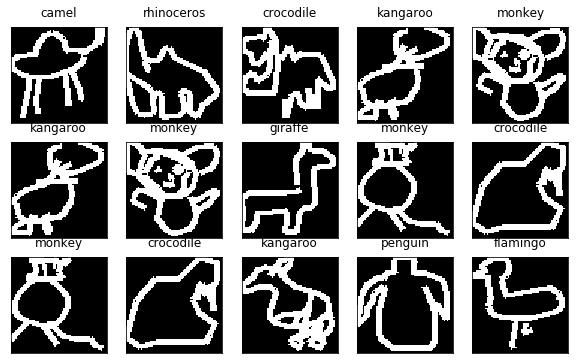

In [6]:
# Visualize some examples from the training set.
from matplotlib import pyplot as plt

def show_img(img_64, title='', ax=None):
  """Shows an image.
  
  Args:
    img_64: Array (or Tensor) with monochrome image data.
    title: Optional title.
    ax: Optional Matplotlib axes to show the image in.
  """
  (ax if ax else plt).matshow(img_64.reshape((64, -1)), cmap='gray')
  if isinstance(img_64, tf.Tensor):
    img_64 = img_64.numpy()
  ax = ax if ax else plt.gca()
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
    
rows, cols = 3, 5
for img_feature, label in train_ds:
  break
_, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for i in range(rows):
  for j in range(cols):
    show_img(img_feature[i*rows+j].numpy(), title=labels[label[i*rows+j].numpy().argmax()], ax=axs[i][j])

## Linear model

In [7]:
# Sample linear model
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
linear_model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

linear_model.compile(
    optimizer=tf.train.AdamOptimizer(),  # Without eager: tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.categorical_accuracy])

linear_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [8]:
linear_model.fit(train_ds,
                 validation_data=eval_ds,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,
                 epochs=1,
                 verbose=True);

Epoch 1/1
500/500 [==============================] - 16s 33ms/step - loss: 1.3979 - acc: 0.5434 - categorical_accuracy: 0.5434 - val_loss: 1.3329 - val_acc: 0.5694 - val_categorical_accuracy: 0.5694


## Convolutional model

In [9]:
# Let's define a convolutional model:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Reshape(target_shape=(64, 64, 1), input_shape=(64, 64)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(10, 10), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4,4)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax'),
])

# YOUR ACTION REQUIRED:
# Compile + print summary of model (analogous to linear model above)
#--snip
conv_model.compile(
    optimizer=tf.train.AdamOptimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        3232      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
__________

In [10]:
# YOUR ACTION REQUIRED:
# Train the model (analogous to linear model above).
# Note: You might want to reduce the number of steps if if it takes too long.
# Pro tip: Change the runtime type ("Runtime" menu) to GPU! After the change you
# will need to rerun the cells above because the Python kernel's state is reset.
#--snip
conv_model.fit(train_ds,
               validation_data=eval_ds,
               steps_per_epoch=steps_per_epoch,
               validation_steps=validation_steps,
               epochs=3,
               verbose=True)

Epoch 1/3
500/500 [==============================] - 36s 73ms/step - loss: 0.7547 - acc: 0.7458 - val_loss: 0.5052 - val_acc: 0.8305
Epoch 2/3
500/500 [==============================] - 33s 67ms/step - loss: 0.4254 - acc: 0.8572
Epoch 3/3
500/500 [==============================] - 34s 67ms/step - loss: 0.3304 - acc: 0.8906


## Store model

In [0]:
os.makedirs(models_path, exist_ok=True)

In [12]:
# Save model as Keras model.
keras_path = os.path.join(models_path, 'linear.h5')
linear_model.save(keras_path)

In [13]:
# Keras model is a single file.
!ls -hl "$keras_path"

-rw------- 1 root root 188K Jan 27 11:47 '/content/gdrive/My Drive/amld_data/models/linear.h5'


In [14]:
# Load Keras model.
# Note: with TensorFlow 1.12 the warning "No training configuration found..." is
# expected. It means that you would need to re-attach a optimizer if you want to
# continue the training. Can be safely ignored for evaluation/prediction.
loaded_keras_model = tf.keras.models.load_model(keras_path)
loaded_keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Save model as Tensorflow Saved Model
saved_model_path_base = os.path.join(models_path, 'saved_model/linear')
saved_model_path = tf.contrib.saved_model.save_keras_model(
    linear_model, saved_model_path_base).decode('utf8')

INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tens

In [16]:
# Inspect saved model directory structure.
!find "$saved_model_path"

/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/assets
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/assets/saved_model.json
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/variables
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/variables/variables.data-00000-of-00001
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/variables/variables.index
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/variables/checkpoint
/content/gdrive/My Drive/amld_data/models/saved_model/linear/1548589642/saved_model.pb


In [17]:
# Load Tensorflow Saved Model.
saved_model = tf.contrib.saved_model.load_keras_model(saved_model_path)
saved_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


In [18]:
# YOUR ACTION REQUIRED:
# Store the convolutional model and any additional models that you trained
# in the previous sections in Keras format so we can use them in later
# notebooks for prediction.
#--snip
conv_model.save(os.path.join(models_path, 'conv.h5'))
!ls -lh "$models_path"

total 1.5M
drwx------ 2 root root 4.0K Jan 26 13:48 competition
-rw------- 1 root root 1.3M Jan 27 11:47 conv.h5
-rw------- 1 root root 188K Jan 27 11:47 linear.h5
drwx------ 3 root root 4.0K Jan 23 08:59 saved_model


# ----- Optional part -----

## Learn from errors

Looking at classification mistakes is a great way to better understand how a model is performing. This section walks you through the necessary steps to load some examples from the dataset, make predictions, and plot the mistakes.

In [0]:
import collections
Mistake = collections.namedtuple('Mistake', 'label pred img_64')
mistakes = []

In [20]:
for img_64_batch, label_onehot_batch in eval_ds:
  break
img_64_batch.shape, label_onehot_batch.shape

(TensorShape([Dimension(100), Dimension(64), Dimension(64)]),
 TensorShape([Dimension(100), Dimension(11)]))

In [0]:
# YOUR ACTION REQUIRED:
# Use model.predict() to get a batch of predictions.
preds = linear_model.predict(img_64_batch)  #preds_batch =

In [22]:
# Iterate through the batch:
for label_onehot, pred, img_64 in zip(label_onehot_batch, preds, img_64_batch):
  # YOUR ACTION REQUIRED:
  # Both label_onehot and pred are vectors with length=len(labels), with every
  # element corresponding to a probability of the corresponding class in
  # "labels". Get the value with the highest value to get the index within
  # "labels":
  label_i = label_onehot.numpy().argmax()  #label_i = 
  pred_i = pred.argmax()  #pred_i =
  if label_i != pred_i:
    mistakes.append(Mistake(label_i, pred_i, img_64.numpy()))

# You can run this cell multiple times to get more
len(mistakes)

48

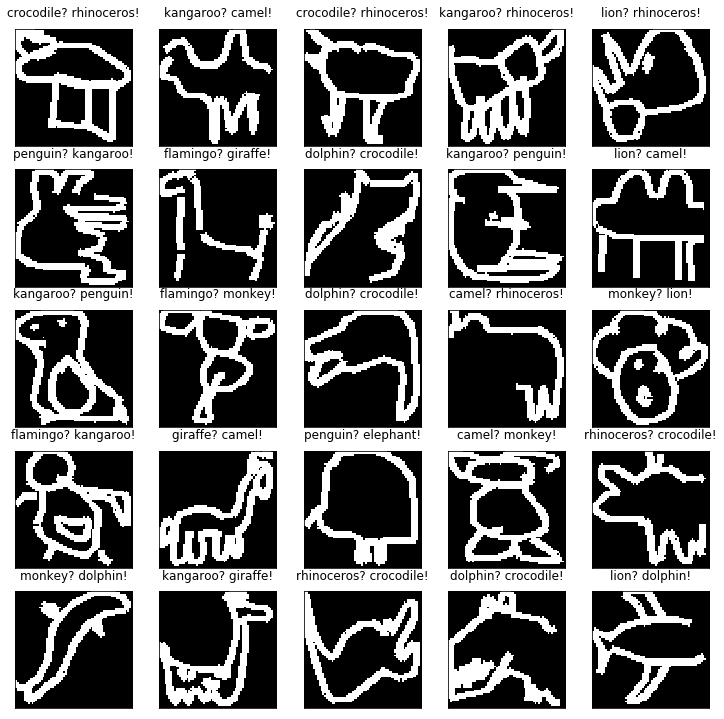

In [23]:
# Let's examine the cases when our model gets it wrong. Would you recognize
# these images correctly?
# YOUR ACTION REQUIRED:
# Create the same plot for a different model and compare the kind of mistakes
# the two models make. Can you spot a pattern?
rows, cols = 5, 5
plt.figure(figsize=(cols*2.5, rows*2.5))
for i, mistake in enumerate(mistakes[:rows*cols]):
  ax = plt.subplot(rows, cols, i + 1)
  title = '{}? {}!'.format(labels[mistake.pred], labels[mistake.label])
  show_img(mistake.img_64, title, ax)

## Data from DataFrame

For comparison, this section shows how you would load data from a `pandas.DataFrame` and then use Keras for training. Note that this approach does not scale well and can only be used for quite small datasets.

In [24]:
# Note free memory BEFORE loading the DataFrame.
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        8.1G        2.1G         17M        2.5G        4.5G
Swap:            0B          0B          0B


In [25]:
# Loading all the data in memory takes a while ...
import pickle
df = pickle.load(tf.gfile.Open('%s/dataframe.pkl' % data_path, mode='rb'))
print(len(df))
print(df.columns)

80000
Index(['countrycode', 'img_64', 'key_id', 'label', 'recognized', 'split',
       'timestamp', 'word'],
      dtype='object')


In [26]:
df_train = df[df.split == b'train']
len(df_train)

50000

In [27]:
# Note free memory AFTER loading the DataFrame.
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G         10G        147M         17M        1.7G        1.6G
Swap:            0B          0B          0B


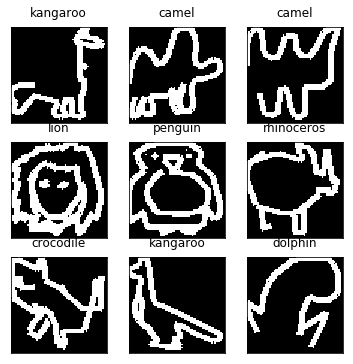

In [28]:
from matplotlib import pyplot as plt

def show_img(img_64, title='', ax=None):
    (ax if ax else plt).matshow(img_64.reshape((64, -1)), cmap='gray')
    ax = ax if ax else plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

rows, cols = 3, 3
_, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for i in range(rows):
  for j in range(cols):
    d = df.sample(1).iloc[0]
    show_img(d.img_64, title=labels[d.label], ax=axs[i][j])

In [0]:
df_x = tf.convert_to_tensor(df_train.img_64 / 255., dtype=tf.float32)
df_y = tf.one_hot(df_train.label, depth=len(labels), dtype=tf.float32)

In [0]:
# Note free memory AFTER defining the Tenors based on the DataFrame.
!free -h

In [0]:
# Checkout the shape of these rather large tensors...
df_x.shape, df_x.dtype, df_y.shape, df_y.dtype

In [0]:
# Copied code from section "Linear model" above.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(64, 64,)))
model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

# How much of a speedup do you see because the data is already in memory?
# How would this compare to the convolutional model?
model.fit(df_x, df_y, epochs=1, batch_size=100)